In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.compose import ReducedRegressionForecaster
from sktime.performance_metrics.forecasting import smape_loss
from sktime.utils.plotting.forecasting import plot_ys
import matplotlib.pyplot as plt

In [2]:
from sktime.datasets import load_airline

In [3]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing

## Exponential Smoothing Flavors
*  Simple Exponential Smoothing : No Trend , No Seasonality
*  Double Exponential Smoothing : Trend , No Seasonality
*  Triple Exponential Smoothing : Trend , Seasonality

In [20]:
FH = 36

In [21]:
airline = load_airline()
train, test = temporal_train_test_split(airline, test_size=FH)
[x.shape for x in [train, test]]

[(108,), (36,)]

In [6]:
fh = np.arange(1,FH + 1)

* Loop to explore different parameters

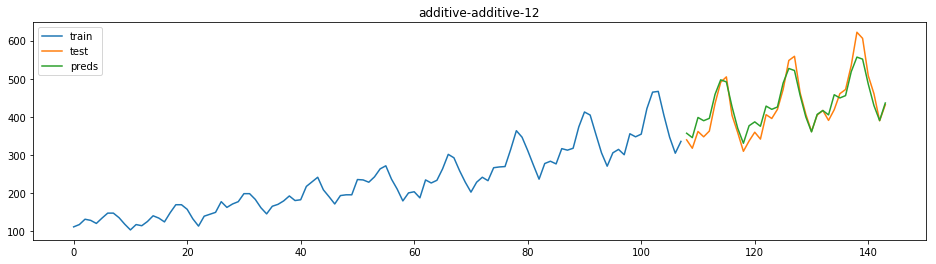

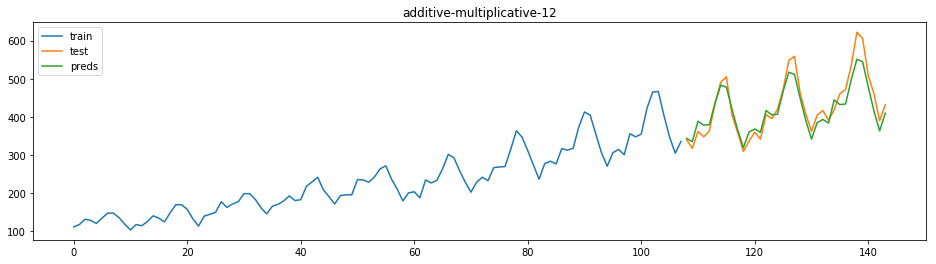

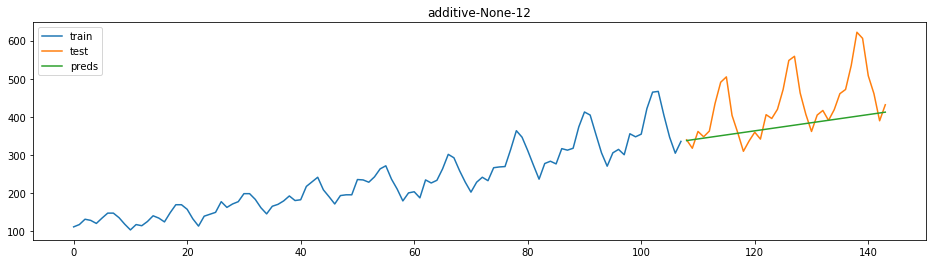

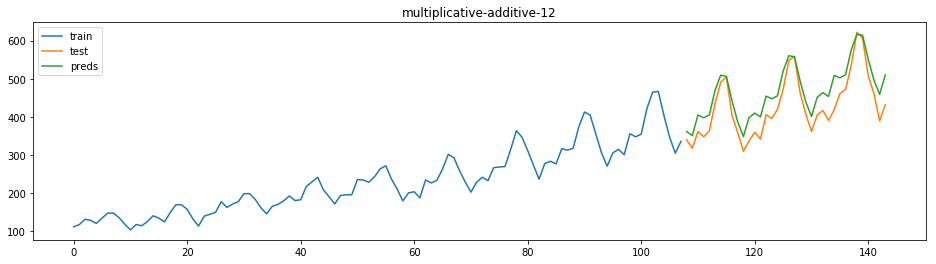

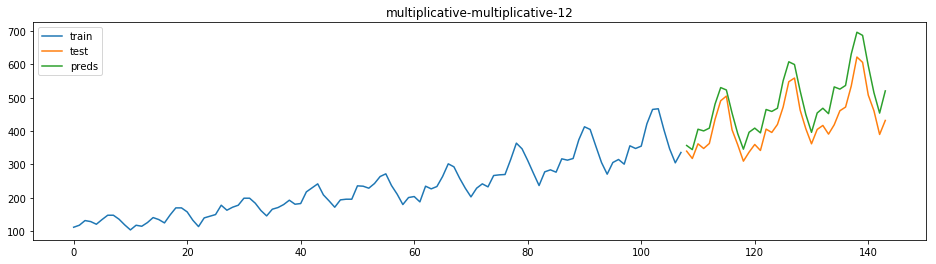

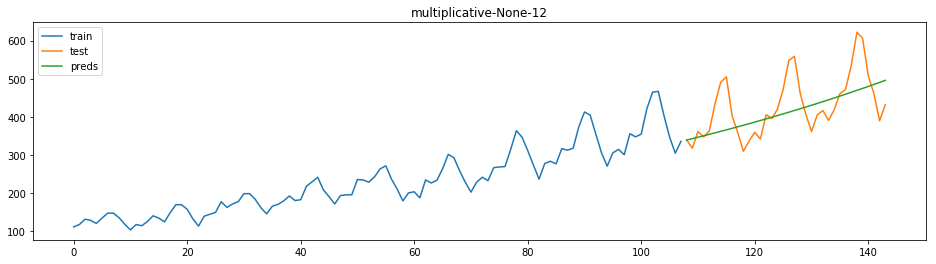

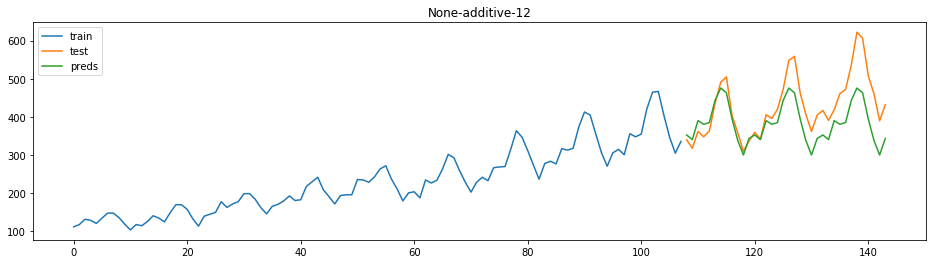

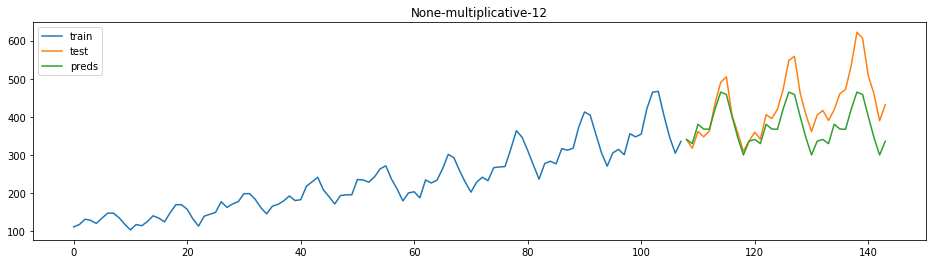

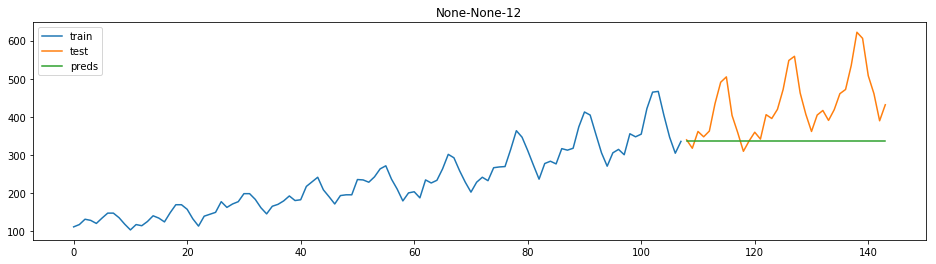

In [7]:
results = {}
for trend in ["additive", "multiplicative", None]:
    for seasonal in ["additive", "multiplicative", None]:
        for sp in [12]:
            mts = ExponentialSmoothing(trend=trend, seasonal=seasonal, sp=sp)
            mts.fit(train)
            y_pred = mts.predict(fh)
            plot_ys(train, test, y_pred, labels=['train', 'test', 'preds'])
            plt.title(f'{trend}-{seasonal}-{sp}')

## Exponential Smoothing Hyper Paramenter Tuning

In [8]:
from sklearn.model_selection import ParameterGrid

* Create extensive parameter grid

In [9]:
params = np.arange(0.05,1.05,0.05)

grid = {
    'trend' : ["additive", "multiplicative"],
    'seasonal' : ["additive", "multiplicative"],
    'damped' : [True,False],
    'sp' : [12],
    'smoothing_level' : params,
    'smoothing_slope' : params,
    'smoothing_seasonal' : params 
}

param_grid = ParameterGrid(grid)
print(f'param_grid : {len(param_grid)}')

param_grid : 64000


* Create a more limited version of the parameter grid

In [10]:
LIMIT = 100
param_grid_limited = np.random.choice(param_grid,LIMIT,replace=False)
print(f'param_grid_limited : {len(param_grid_limited)}')

param_grid_limited : 100


In [11]:
results = {}
for enum,g in enumerate(param_grid_limited):
    mts = ExponentialSmoothing(**g)
    mts.fit(train)
    y_pred = mts.predict(fh)
    results[enum] = smape_loss(test,y_pred)

C:\Users\Takis\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,
C:\Users\Takis\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,
C:\Users\Takis\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,
C:\Users\Takis\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,
C:\Users\Takis\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


In [12]:
results = {k: v for k, v in sorted(results.items(), key=lambda item: item[1])}
print(list(results.items())[:5])

top_5_indices = dict(list(results.items())[:5]).keys()
print(top_5_indices)

best_index = list(dict(list(results.items())[:1]).keys())[0]
print(best_index)

[(65, 0.045699848649975595), (62, 0.046830345843134766), (43, 0.04699252268154233), (42, 0.047686174823794066), (46, 0.05147146402774349)]
dict_keys([65, 62, 43, 42, 46])
65


In [13]:
optimal_grid = param_grid_limited[best_index]
optimal_grid

{'damped': False,
 'seasonal': 'multiplicative',
 'smoothing_level': 0.7500000000000001,
 'smoothing_seasonal': 0.9000000000000001,
 'smoothing_slope': 0.2,
 'sp': 12,
 'trend': 'multiplicative'}

Text(0.5, 1.0, "['damped : False', 'seasonal : multiplicative', 'smoothing_level : 0.7500000000000001', 'smoothing_seasonal : 0.9000000000000001', 'smoothing_slope : 0.2', 'sp : 12', 'trend : multiplicative']")

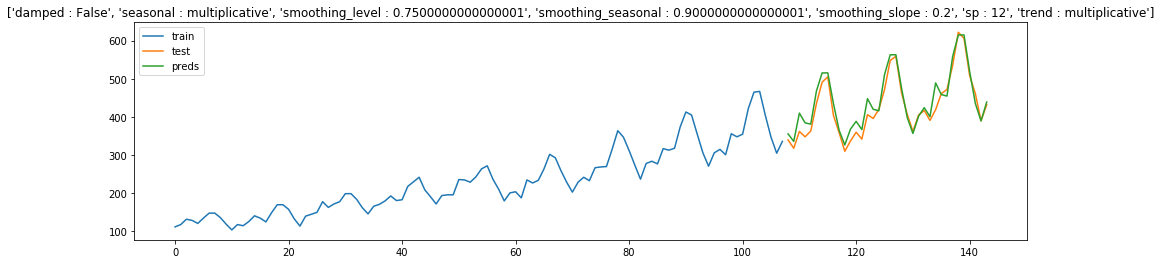

In [14]:
mts = ExponentialSmoothing(**optimal_grid)
mts.fit(train)
y_pred = mts.predict(fh)
plot_ys(train, test, y_pred, labels=['train', 'test', 'preds'])
plt.title(f'{[str(k)+" : "+str(v) for k,v in optimal_grid.items()]}')

## Exponential Smoothing AutoETS

In [17]:
from sktime.forecasting.ets import AutoETS

(<Figure size 1152x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x296b54717f0>)

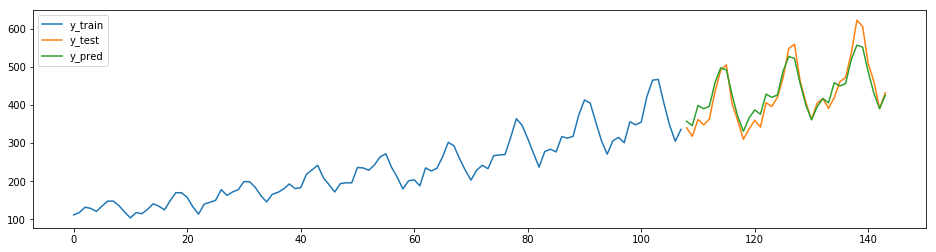

In [29]:
forecaster = AutoETS(trend='add',seasonal='add',sp=12)
forecaster.fit(train)
y_pred = forecaster.predict(fh)
plot_ys(train, test, y_pred, labels=["y_train", "y_test", "y_pred"])